In [28]:
import numpy as np
from json import load
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_colwidth', 80)

In [29]:
# Load train, test is not loaded to keep memory usage down.
train_pd = pd.read_json(open("../Data/train.json"))
print(train_pd.head(10))
print(train_pd.dtypes)

       cuisine     id  \
0        greek  10259   
1  southern_us  25693   
2     filipino  20130   
3       indian  22213   
4       indian  13162   
5     jamaican   6602   
6      spanish  42779   
7      italian   3735   
8      mexican  16903   
9      italian  12734   

                                                                       ingredients  
0  [romaine lettuce, black olives, grape tomatoes, garlic, pepper, purple onion...  
1  [plain flour, ground pepper, salt, tomatoes, ground black pepper, thyme, egg...  
2  [eggs, pepper, salt, mayonaise, cooking oil, green chilies, grilled chicken ...  
3                                              [water, vegetable oil, wheat, salt]  
4  [black pepper, shallots, cornflour, cayenne pepper, onions, garlic paste, mi...  
5  [plain flour, sugar, butter, eggs, fresh ginger root, salt, ground cinnamon,...  
6  [olive oil, salt, medium shrimp, pepper, garlic, chopped cilantro, jalapeno ...  
7  [sugar, pistachio nuts, white almond bark

In [3]:
# Print the unique cuisine types
print(train_pd.cuisine.unique())

['greek' 'southern_us' 'filipino' 'indian' 'jamaican' 'spanish' 'italian'
 'mexican' 'chinese' 'british' 'thai' 'vietnamese' 'cajun_creole'
 'brazilian' 'french' 'japanese' 'irish' 'korean' 'moroccan' 'russian']


In [4]:
# Obtain all the ingredients listed
all_ingredient = {}
for ingredient_ls in train_pd.ingredients:
    for ingredient in ingredient_ls:
        if ingredient.lower() in all_ingredient.keys():
            all_ingredient[ingredient.lower()] += 1
        else:
            all_ingredient[ingredient.lower()] = 1

In [5]:
ingredient_map = {'ingredient':list(all_ingredient.keys()), 'vals':list(all_ingredient.values())}
ingredient_count_df = pd.DataFrame(ingredient_map)
ingredient_count_df.head(10)

,ingredient,vals
0,romaine lettuce,270
1,black olives,229
2,grape tomatoes,228
3,garlic,7380
4,pepper,4438
5,purple onion,1896
6,seasoning,137
7,garbanzo beans,148
8,feta cheese crumbles,358
9,plain flour,154


In [6]:
print("The total number of ingredients: {}".format(ingredient_count_df.ingredient.count()))
print("The number of ingredient's that are listed once are: {}".format(np.sum(ingredient_count_df.vals == 1)))
print("The number of ingredient's that are listed less than 10 times is: {}".format(np.sum(ingredient_count_df.vals < 10)))

The total number of ingredients: 6703
The number of ingredient's that are listed once are: 1756
The number of ingredient's that are listed less than 10 times is: 4302


In [7]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(ingredient_count_df[ingredient_count_df.vals == 1])

                                             ingredient  vals
64                                    white almond bark     1
232               johnsonville andouille dinner sausage     1
286                                     lemon olive oil     1
363                                  taiwanese bok choy     1
378                                           membrillo     1
445                                      chestnut flour     1
499                            cinnamon graham crackers     1
570                                     chorizo spanish     1
619                    instant butterscotch pudding mix     1
808                                      guinness lager     1
831                                    franks hot sauce     1
901                                           pecan pie     1
961                          whole grain thin spaghetti     1
977                                   blueberri preserv     1
986                      wish bone guacamol ranch dress     1
1000    

In [8]:
# Print potential equivalencies
equiv = {}
for not_one_ingred in ingredient_count_df.ingredient[ingredient_count_df.vals > 1]:
    for one_inreg in ingredient_count_df.ingredient[ingredient_count_df.vals == 1]:
        if not_one_ingred in one_inreg:
            if not_one_ingred not in equiv:
                equiv[not_one_ingred] = [one_inreg]
            else:
                equiv[not_one_ingred].append(one_inreg)

In [9]:
def print_pretty(dic, head=3):
    """
    Prints a dictionary out in a pretty manner
    Head can be an integer or "all", and will print out so many keys
    """
    i = 0
    for key, value in dic.items():
        i += 1
        if head != "all" and i > head:
            return
        print(key)
        for word in value:
            print("\t{}".format(word))
print_pretty(equiv)

black olives
	greek black olives
garlic
	black bean sauce with garlic
	garlic mayonnaise
	knorr italian side   creami garlic shell
	garlic naan
	flowering garlic chives
	garlic olive oil
	garlic herb spreadable cheese
	spice islandsâ® minced garlic
	soy vayâ® hoisin garlic marinade & sauce
	roasted garlic oil
	black garlic
	garlic pepper blend
	spice islands garlic salt
	stonefire tandoori garlic naan
	tomato garlic pasta sauce
pepper
	ground roasted sichuan peppers
	margherita pepperoni
	mccormick ground white pepper
	mini pepperoni slices
	kraft shredded pepper jack cheese with a touch of philadelphia
	pepper leaves
	peppermint schnapps
	blackpepper
	crushed peppermint candy
	roasted bell peppers
	tabascoâ® chipotle pepper sauce
	padron peppers
	dried chipotle pepper
	pointed peppers
	kraft big slice pepper jack cheese slices
	long green pepper
	bird pepper
	sichuan peppercorn oil
	fresno pepper
	pepper cheese
	kraft shredded pepper jack cheese
	chinese pepper
	garlic pepper blend
	c

This gives good results, but I need to make sure if I make a substitution, than I need to watch for cases like this:  
eel  
*	wagon wheels
*	candied citron peel
*	pasta wagon wheel
*	darjeeling tea leaves
*	meyer lemon peel
*	citrus peel
*	smoked eel
*	raw peeled prawns
*	peeled canned low sodium tomatoes
*	conger eel
*	peeled diced tomatoes  
I should be able to fix this by ensuring only whole words can match each other, otherwise wagon wheels are going to be taken as wheels

### Summary  
A lot of the ingredients are already listed, but they are listed with another word next to the main ingredient, so things like "rye flour" will come in commonly, but then "dark rye bread" will come in too, and so generate a new ingredient.

I will use common ingredients to reduce the number of one of ingredients. I am not entirely sure what to do about grouped ingredients for instance "garlic naan" comes up under both "garlic", and "naan". I think the most sensible thing to do is count them as both.

Using regular expression I can use ```(?:^|\s)eel(?:$|\s)```. This will match eel so long as it is a whole word independent of if it is at the start, end, or middle of the words.

In [10]:
import re

In [11]:
# Try making each ingredient a list of words, to remove the eel problem.
equiv_br_by_wrd = {}
for not_one_ingred in ingredient_count_df.ingredient[ingredient_count_df.vals > 1]:
    reg_obj = re.compile("(?:^|\s){}(?:$|\s)".format(not_one_ingred))
    for one_ingred in ingredient_count_df.ingredient[ingredient_count_df.vals == 1]:
        matches = reg_obj.search(one_ingred)
        if matches != None:
            if not_one_ingred not in equiv_br_by_wrd:
                equiv_br_by_wrd[not_one_ingred] = [one_ingred]
            else:
                equiv_br_by_wrd[not_one_ingred].append(one_ingred)

In [12]:
print_pretty(equiv_br_by_wrd, "all")

black olives
	greek black olives
garlic
	black bean sauce with garlic
	garlic mayonnaise
	knorr italian side   creami garlic shell
	garlic naan
	flowering garlic chives
	garlic olive oil
	garlic herb spreadable cheese
	spice islandsâ® minced garlic
	soy vayâ® hoisin garlic marinade & sauce
	roasted garlic oil
	black garlic
	garlic pepper blend
	spice islands garlic salt
	stonefire tandoori garlic naan
	tomato garlic pasta sauce
pepper
	mccormick ground white pepper
	kraft shredded pepper jack cheese with a touch of philadelphia
	pepper leaves
	tabascoâ® chipotle pepper sauce
	dried chipotle pepper
	kraft big slice pepper jack cheese slices
	long green pepper
	bird pepper
	fresno pepper
	pepper cheese
	kraft shredded pepper jack cheese
	chinese pepper
	garlic pepper blend
seasoning
	creole seasoning mix
	roast pork seasoning mix
	adobo all purpose seasoning
	lamb seasoning
	cavenders greek seasoning
	barbecue seasoning
	vegeta seasoning
	ladys house seasoning
	adobo style seasoning
	ess

pan drippings
	chicken pan drippings
chinese celery
	chinese celery cabbage
drippings
	duck drippings
	chicken pan drippings
	meat drippings
masala
	whole garam masala
	curry guy smoked garam masala
	tandoori masala mix
cabernet sauvignon
	hogue cabernet sauvignon
pig
	suckling pig
hot dogs
	turkey hot dogs
	beef hot dogs
italian style stewed tomatoes
	reduced sodium italian style stewed tomatoes
garlic chives
	flowering garlic chives
caviar
	osetra caviar
	salmon caviar
	trout caviar
smoked bacon
	double smoked bacon
cocoa
	dark chocolate cocoa powder
chicken thigh fillets
	boneless skinless chicken thigh fillets
red
	old el pasoâ„¢ mild red enchilada sauce
	chinese red vinegar
	red drum
	klondike rose red skin potato
	red anjou pears
	red wine vinaigrette
	red mustard
	red vinegar
	red chard
	red vinegar white white, wine,
	red grapefruit juice
	wish bone red wine vinaigrett dress
	sweetened red beans
	camellia red kidney beans
	la victoria red chile sauce
	red currants
	red quinoa
	

## Atomicity
My question now is, given all of these ingredients should I use a list of ingredients that others are made up of, or should I use the largest possible words other ingredients are made up of. For instance, the following ingredient turned up  

*low fat mild italian turkey sausage*

So when I break this up as I had, it comes up as turkey, italian turkey sausage and turkey sausage. So the question transforms to, should I mark something by it's most basic components (atoms), or it's longest (molecules).
### Brand names
TODO: I want to see what the longest worded ingredients are. Are the really long ones only branded named ingredients?

<IPython.core.display.Javascript object>


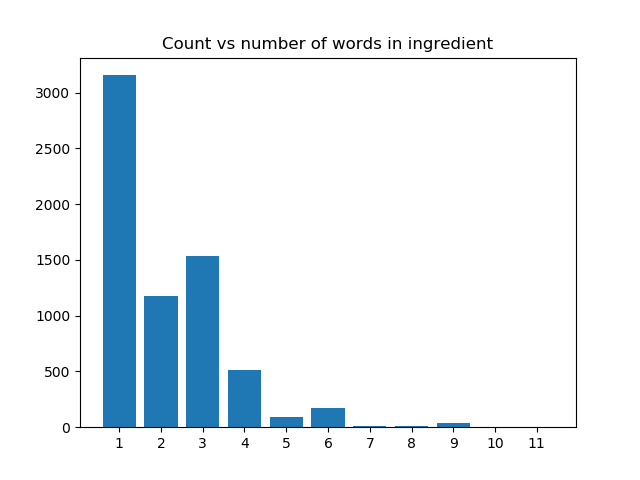

Text(0.5,1,'Count vs number of words in ingredient')

In [17]:
%matplotlib notebook
grouped_by_num_wrds = {}
for ingredient in ingredient_count_df.ingredient:
    ingred_int = len(ingredient.split(" "))
    try:
        grouped_by_num_wrds[ingred_int].append(ingredient)
    except KeyError:
        grouped_by_num_wrds[ingred_int] = [ingredient]
        
count_of_words = []
for i in sorted(grouped_by_num_wrds.keys()):
    count_of_words.append(len(grouped_by_num_wrds[i]))

plt.bar(grouped_by_num_wrds.keys(), count_of_words)
plt.xticks(list(grouped_by_num_wrds.keys()))
plt.title("Count vs number of words in ingredient")


It can be seen above that ingredients with 1 up to 4 words in their ingredient name are most common. Let's see the ones with more than 4 words in the ingredient

In [30]:
ingredient_count_df["num_words"] = ingredient_count_df.ingredient.apply(lambda ingredient: len(ingredient.split(" ")))
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(ingredient_count_df[ingredient_count_df.num_words > 4].sort_values(by=["num_words", "vals"], ascending=False).head(10))

                                                                 ingredient  \
3879              i can't believ it' not butter! made with olive oil spread   
6006  kraft mexican style shredded four cheese with a touch of philadelphia   
6172                        2 1/2 to 3 lb. chicken, cut into serving pieces   
4808         kraft shredded pepper jack cheese with a touch of philadelphia   
952      bertolli vineyard premium collect marinara with burgundi wine sauc   
3542                  i can't believe it's not butter!â® all purpose sticks   
3227            condensed reduced fat reduced sodium cream of mushroom soup   
5728             condensed reduced fat reduced sodium cream of chicken soup   
1988               (10 oz.) frozen chopped spinach, thawed and squeezed dry   
3897        hidden valleyâ® original ranch saladâ® dressing & seasoning mix   

      vals  num_words  
3879     2         11  
6006     1         11  
6172     2         10  
4808     1         10  
952      5

Looking at these words there are a couple of obvious changes to the ingredients.
* The ingredients include their brand in the long ingredients:
    + kraft mexican style 2% milk finely shredded four cheese
    + ro-tel diced tomatoes & green chilies
* The ingredients include their portions and what to do to them
    * 2 1/2 to 3 lb. chicken, cut into serving pieces

I want to find the average number of counts these words have, so I can decide a cut off word size.

In [31]:
ingredient_count_df.groupby("num_words").mean()

,vals
num_words,
1,118.507234
2,67.891353
3,40.899220
4,17.472763
5,10.845238
6,9.483146
7,2.828571
8,1.307692
9,2.400000


In [32]:
ingredient_count_df.groupby("num_words").median()

,vals
num_words,
1,7.0
2,5.0
3,4.0
4,2.0
5,2.0
6,1.0
7,1.0
8,1.0
9,2.0


In [33]:
ingredient_count_df.groupby("num_words").skew()

,vals
num_words,
1,15.911842
2,12.811276
3,14.005856
4,9.667080
5,10.449633
6,9.202440
7,3.107474
8,3.078409
9,0.772417


Almost all the numbers of words have a substantial positive skew, which brings the mean over each group up substantially. The median is a much better number to go off of for this. So, anything over 5 words has substantially small counts for more than half of the ingredients. I propose removing any ingredients with more than 5 words. Anything above can be broken for other words like the turkey sausage example. 
# Using TF-IDF on these
Perhaps I can use TF-IDF to generate each one of conditions that I have put on the ingredients. The include all words less than 5 words can be included, with bigrams, unigrams etc. The exclude all words with 1 word or less can be much more stringent and easily changed. I can also get rid of words that are still too common. 

# Need to look into correlations.